- dc neuron example [here](https://nest-simulator.readthedocs.io/en/stable/auto_examples/brette_gerstner_fig_3d.html?highlight=dc_generator) [ and here](https://nest-simulator.readthedocs.io/en/stable/auto_examples/tsodyks_depressing.html?highlight=dc_generator#see-also)

```Python
set_params()
build_network()
    
for p in range(len(patterns)):
    set_pattern(p)
    simulate()

```

## The question is: how to stimulate neurons

for the `dc_generator` we have 4 options:

1. create the dc generators just once (in method `build_network`) and only change the neurons to which they connect in the for loop. --> seems like the most optimal solution
    - Q: does Nest allow this? --> so far **NO** (global error)
2. create the dc generators for every iteration and change connectivity each time --> global error
3. create just one dc_generator, connect it to all neurons and use `SetStatus()` to alternate the stimulation amplitude based on the given pattern. --> **NO**

> **CURRENTLY**. create a single dc generator FOR EACH neuron, assign the amplitude later based on the given pattern.


IDEAS
- maybe have to change the amplitudes

In [36]:
# nest
import nest
import nest.raster_plot
import nest.voltage_trace
# other
import pandas as pd
import os
import json
import time 
import timeit
import itertools
import numpy as np
from importlib import reload 
from itertools import permutations 
from itertools import combinations 
import matplotlib.pyplot as plt
import seaborn as sns
# horay for beautiful plots
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# 0 Set parameters

In [37]:
sim_params = {
        
        'N_total':1200,
        'NE': 960, # Default: 4/5 are exci neurons, 1/5 are inh neurons
        'NI': 240,
        'eps':0.1,  # connection probability
        'J_in':-96.0,
        'J_ex':6.0,
        'resolution':0.1,  # temporal resolution of simulation in ms. Kumar2008: 0.1
        'delay':1.5,  # synaptic delay in the network
        'n_threads':8,
        'stim_start':0., # start applying current (dc)
        'stim_end':100., # end applying current (dc)
        'simtime':1000., # simulation time 
        'sub_fr':0.9, # subthreshold current amplitude
        'sup_fr':1.01, # suprathreshold current amplitude
    }

model_params = {
        
        'C_m': 250.0,
        'E_L': -70.0,
        'E_ex': 0.0,
        'E_in': -80.0,
        'I_e': 0.0,
        'V_reset': -70.0,
        'V_th': -50.0,
        'g_L': 16.7,
        't_ref': 2.0, # Duration of refractory period
        'tau_syn_ex': 0.326, # Rise time of the excitatory synaptic alpha function
        'tau_syn_in': 0.326,
    }
    
syn_params_ex = {
    
        'model':'stdp_synapse',
        'lambda': 0.01,
        'alpha': 1.0,
        'delay': 1.5,
        'weight': 6.0,
        'Wmax': 100.0   
    }
    
syn_params_in = {
    
        'model':'stdp_synapse',
        'lambda': 0.01,
        'alpha': 1.0,
        'delay': 1.5,
        'weight':-95.0,
        'Wmax':-100.0  
    }

stim_amps = [300.6, 337.34]

# 1 Make patterns 

(adding code later)

In [38]:
pattern = [1, 1, 1, 0, 0, 1, 0, 0]

# 2 Build network

## 2.1 Reset kernel and set resolution

- Reset the simulation kernel (ensure that previous NEST simulations in the python shell will not disturb this simulation)
- set the simulation resolution

In [39]:
nest.ResetKernel() 
nest.SetKernelStatus({'resolution': 0.1, 'print_time': False, 'local_num_threads': 8})

## 2.2 Create the neurons, generator and meters

- create a population of neurons with specified neuron model and parameters defined above
- create a spikedetector that tracks when the neurons spike
- create a multimeter that tracks the voltage of neurons
- create a dc generator, that will apply a constant current to the neurons

--- 

**Multimeter** replaces a range of analog recording devices, such as voltmeter, conductancemeter and aeif_w_meter

---

### Order

- `Create()`
- `SetStatus()`
- `Connect()`

In [40]:
# ====== CREATE NEURONS =========
neuron_ids = nest.Create('iaf_cond_alpha', 1200, params=model_params)

#  ====== CREATE & CONFIGURE GENERATORS + DETECTORS =========
# create & configure dc generators (inputs)
nest.SetDefaults('dc_generator', {'start': 0., 'stop': 100.})
dcgens = nest.Create('dc_generator', 1200)

# create and configure spikedetector
spikedet = nest.Create('spike_detector')
nest.SetStatus(spikedet, params={"withgid": True, "withtime": True})

# create and configure multimeter that records the voltage (V_m)
multimet = nest.Create('multimeter', params={'record_from': ['V_m']})
nest.SetStatus(multimet, params={'interval':1.})

## 2.3 Wire

### 2.3.1 Connect neurons to detectors

The command `Connect` has different variants. Plain `Connect` just takes the handles of pre- and post-synaptic nodes and uses the default values for weight and delay. Note that the connection direction for the voltmeter reflects the signal flow in the simulation kernel, because it observes the neuron instead of receiving events from it.

In [41]:
# ====== CONNECT TO DEVICES =========
nest.Connect(neuron_ids, spikedet)
nest.Connect(multimet, neuron_ids)
nest.Connect(dcgens, neuron_ids, 'one_to_one')

# # connect dc_generators to neuron populations
# nest.Connect(dcgen_sub, neurons_sub)
# nest.Connect(dcgen_supra, neurons_supra)

### 2.3.2 Make connections between and within neuron populations

- the neurons within the two populations are randomly connected with a probability $\epsilon = 0.1$
- we define all the excitatory synapses to be STDP and the inhibitory synapses to be static

### Old way to define synapses

In [42]:
# ====== DEFINE SYNAPSES & CONNECTIVITY RULE =========
nest.CopyModel(existing='static_synapse', new='syn_ex', params={'weight':6.0, 'delay': 1.5})
nest.CopyModel(existing='static_synapse', new='syn_in', params={'weight':-96.0, 'delay': 1.5})

conn_dict = {'rule': 'pairwise_bernoulli', 'p': 0.1} 

# ===== CONNECT NEURONS ======
nest.Connect(neuron_ids[:960], neuron_ids, conn_spec=conn_dict, syn_spec='syn_ex' )
nest.Connect(neuron_ids[960:], neuron_ids, conn_spec=conn_dict, syn_spec='syn_in' )

### Better way??

In [43]:
# # ====== DEFINE SYNAPSES & CONNECTIVITY RULE =========
# conn_dict = {'rule': 'pairwise_bernoulli', 'p': 0.1} 

# static_ex_params = {'model':'static_synapse','weight':6.0, 'delay':1.5}
# static_in_params = {'model':'static_synapse','weight':-96.0, 'delay':1.5}

# # ===== CONNECT NEURONS ======

# nest.Connect(neuron_ids[:960], neuron_ids, conn_dict, static_ex_params)
# nest.Connect(neuron_ids[960:], neuron_ids, conn_dict, static_in_params)

# # # UNCOMMENT FOR STDP
# # # make connections between the two populations
# # # from excitatory neurons to all neurons
# # nest.Connect(neuron_ids[:960], neuron_ids, conn_dict, syn_params_ex)
# # # from interneurons to all neurons
# # nest.Connect(neuron_ids[240:], neuron_ids, conn_dict, static_in_params)

### 2.3.3 Check the synapses

`GetConnections(source=None, target=None, synapse_model=None)` returns a list of connection identifiers that match the given specifications. There are no mandatory arguments. If it is called without any arguments, it will return all the connections in the network.

See [quering the synapses](https://nest-simulator.readthedocs.io/en/stable/tutorials/pynest_tutorial/part_3_connecting_networks_with_synapses.html#querying-the-synapses)

# 3 Set a pattern

use `SetStatus()` to set the right amplitude for the dcgenerators.

Choose between:
- Assignment option I
- Assignment option II

```Python
## trying stuff out
# e = np.arange(120)
# print(e)
# assignments = e%8
# np.where(assignments == 1)[0]
```

## Assignment option I
- get indices list and do % 8 to get a list of len 1200 consisting of repeated 0-7 nums
- set the status of each dc_generator (i.e. the amplitude) based on the pattern

In [44]:
# # make assignments (returns list of 1200 items in a range from 0-7)
# ass = np.arange(1200)%8

# for i in range(len(pattern)):
#     # get the indices of all stimulator indices that are i (a number between 0-7)
#     stims_i = np.where( ass == i )[0]
#     #print(len(stims_i))

#     # assign the right amplitude to these
#     digit = pattern[i]
#     nest.SetStatus( list(np.array(dcgens)[stims_i]), params={'amplitude': stim_amps[digit]} )

## Assignment option II

- divide neuron indices in groups of 150 (8 groups)
- stimulate either with sub or supra Amplitude based on pattern

In [45]:
n_chunk = int(1200/8)
indices = list(range(1200))

# divide neuron indices in N chunks (groups)
make_n_chunks = [indices[i:i + 150] for i in range(0, len(indices), n_chunk)]

for i in range(len(pattern)):

    stims_i = make_n_chunks[i]
    #print(type(stims_i))
    digit = pattern[i] # >>> 0 or 1
    nest.SetStatus( list(np.array(dcgens)[stims_i]), params={'amplitude': stim_amps[digit]} )

# 4 Simulate

In [46]:
#nest.ResetNetwork() # forget all previous simulation data
nest.SetKernelStatus({'time':0.}) # turn back the clock
# simulate for a certain time period (ms)
nest.Simulate(1000.)

# 5 Obtain data and plot

## 5.1 Get the data 

In [47]:
#nest.GetStatus(spikedet, 'events')[0]
#nest.GetStatus(multimet)[0]['events']

In [48]:
# spike detector data
spike_times = nest.GetStatus(spikedet, 'events')[0]['times']
spike_neurons = nest.GetStatus(spikedet, 'events')[0]['senders']

# multimeter data
events = nest.GetStatus(multimet)[0]['events']
etimes = events['times']

## 5.2 Make raster plot & plot membrane potential

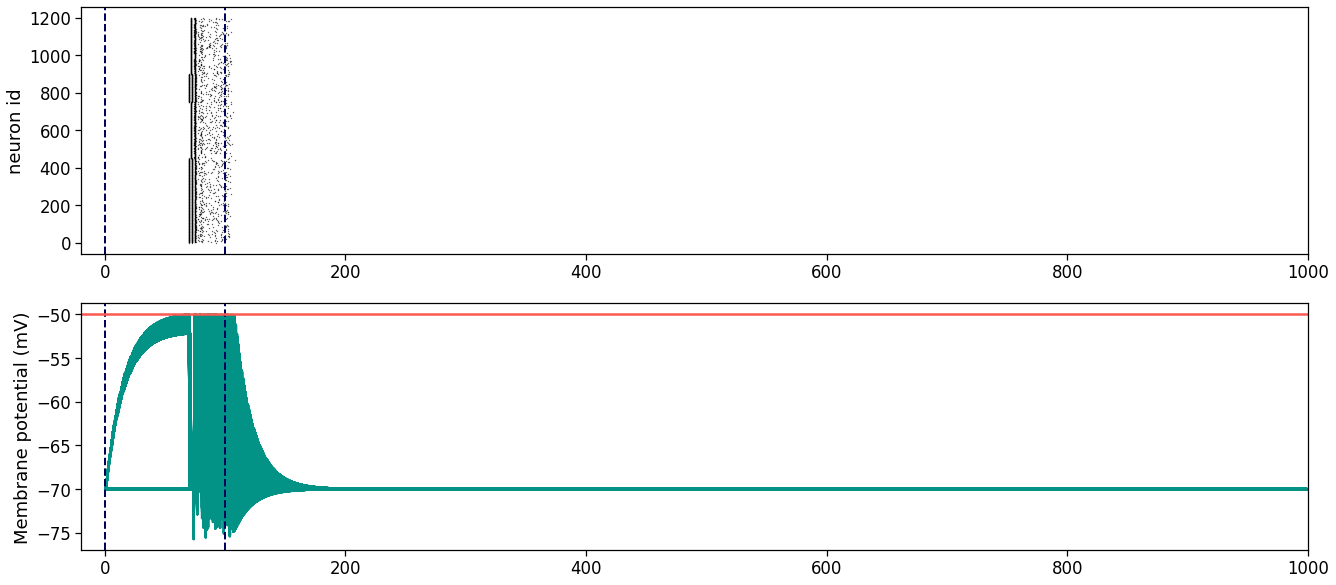

In [55]:
# ==== PLOT ====
fig, (ax1, ax2) = plt.subplots(2, figsize=(22,10))

# raster plot
ax1.scatter(spike_times, spike_neurons, marker='o', s=0.08, color='k');
ax1.set_ylabel('neuron id')
ax1.axvline(x=0, linewidth=2., color='xkcd:dark blue', linestyle='--')
ax1.axvline(x=100., linewidth=2., color='xkcd:dark blue', linestyle='--')
ax1.set_xlim([-20, 1000])

# voltage
ax2.plot(etimes, events['V_m'], color='xkcd:teal')
ax2.set_ylabel('Membrane potential (mV)')
ax2.axvline(x=0, linewidth=2., color='xkcd:dark blue', linestyle='--')
ax2.axvline(x=100., linewidth=2., color='xkcd:dark blue', linestyle='--')
ax2.axhline(y=-50, linewidth=2.5, color='xkcd:coral', linestyle='-')
ax2.set_xlim([-20, 1000]);

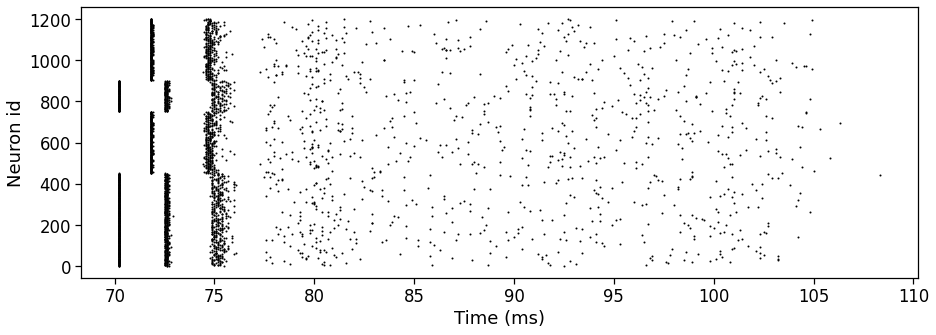

In [56]:
f = plt.figure(figsize=(15,5))
plt.scatter(spike_times, spike_neurons, marker='o', s=1., color='k');
plt.xlabel('Time (ms)')
plt.ylabel('Neuron id');

## If you used option II, have to reorder spikes

In [35]:
def reorder(neuronids,numgroups=8, numneurons=1200, offset=1):
    
    neworder = []
    # Per group neuron counts
    Gr = np.array([len(np.where(np.arange(numneurons)%numgroups==n)[0]) for n in range(numgroups-1)])
    # CS_Gr = cumsum(circshift(hstack([0,Gr]),-1))
    Gr = np.cumsum(np.hstack([0,Gr]))
    Gr = np.array(circshift(Gr,offset))
    for s in neuronids:
        o = s // numgroups
        g = s % numgroups
        neworder.append(Gr[g] + o)
        # neworder.append(int(sum(Gr[0:g]) + o))
        # group.append(g)
    # print "last neuron id to fire (reordered): "+str(max(array(neworder)))
    return neworder

def circshift(V, offset=0):
    
    l = len(V)
    if type(V) is list:
        return V[-offset%l:]+V[:-offset%l]
    elif type(V) is np.ndarray:
        return list(V[-offset%l:])+list(V[:-offset%l])

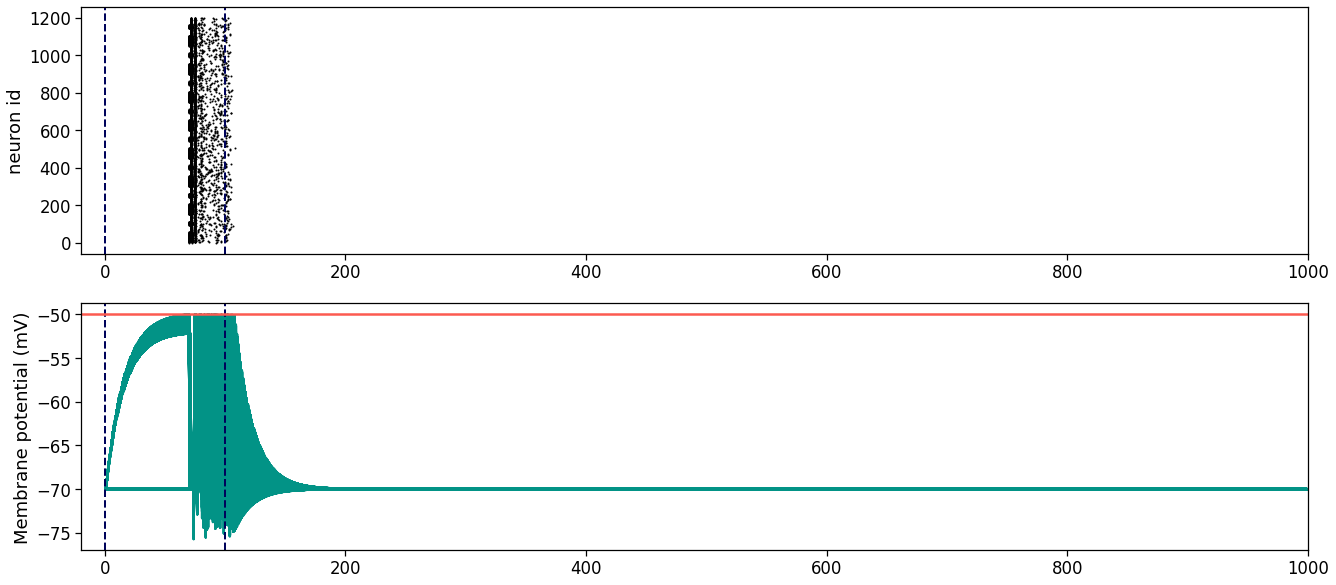

In [51]:
# reorder the spikes
NO = reorder(spike_neurons)

# ==== PLOT ====
fig, (ax1, ax2) = plt.subplots(2, figsize=(22,10))

# raster plot
ax1.scatter(spike_times, NO, marker='o', s=1, color='k');
ax1.set_ylabel('neuron id')
ax1.axvline(x=0, linewidth=2., color='xkcd:dark blue', linestyle='--')
ax1.axvline(x=100., linewidth=2., color='xkcd:dark blue', linestyle='--')
ax1.set_xlim([-20, 1000])

# voltage
ax2.plot(etimes, events['V_m'], color='xkcd:teal')
ax2.set_ylabel('Membrane potential (mV)')
ax2.axvline(x=0, linewidth=2., color='xkcd:dark blue', linestyle='--')
ax2.axvline(x=100., linewidth=2., color='xkcd:dark blue', linestyle='--')
ax2.axhline(y=-50, linewidth=2.5, color='xkcd:coral', linestyle='-')
ax2.set_xlim([-20, 1000]);

## Old code

In [24]:
# # ====== SIMULATE =========
# # simulate for a certain time period (ms)
# nest.Simulate(self.simtime)

# # spike detector data
# spike_times = nest.GetStatus(spikedet, 'events')[0]['times']
# spike_neurons = nest.GetStatus(spikedet, 'events')[0]['senders']

# # multimeter data
# events = nest.GetStatus(multimet)[0]['events']
# etimes = events['times']

# return spikedet, multimet, events, etimes, spike_times, spike_neurons

In [52]:
# # pick some random indices
# rnd_indices = np.random.randint(1200,size=4)
# # voltage trace of few neurons
# f = plt.figure(figsize=(22,5))
# nest.voltage_trace.from_device(multimet, neurons=rnd_indices, title='Potential of some random neurons');
# positions = (0, 100, 500, 1000)
# labels = ('Stim start', 'Stim end', 500, '1000')
# plt.xticks(positions, labels);
# plt.axhline(y=-50, linewidth=2., color='xkcd:fuchsia', linestyle='--')
# plt.legend();

In [28]:
# # make lists for the neurons that should receive a sub and supra amplitude
# sub_amp_ids = []
# supra_amp_ids = []

# # divide the indices to sub or supra based on the given pattern
# for i in range(len(pattern)):
    
#     if pattern[i] == 0:
#         #sub_amp_ids.append(make_n_chunks[i])
#         nest.SetStatus(dcgen, params={'amplitude': 300.6})
        
#     elif pattern[i] == 1:
#         #supra_amp_ids.append(make_n_chunks[i])
#         nest.SetStatus(dcgen, params={'amplitude':337.34})
        
# # # need to convert list of tuples to one tuple for nest
# # neurons_sub = tuple([item for sublist in sub_amp_ids for item in sublist])
# # neurons_supra = tuple([item for sublist in supra_amp_ids for item in sublist])

In [ ]:
# #====== DC GENERATORS ======
# # create two independent dc generators that will both stimulate a different subset of neurons
# # dcgen_sub = nest.Create('dc_generator')
# # dcgen_supra = nest.Create('dc_generator')

# nest.SetStatus(dcgen_sub, params={'amplitude': 300.6, 'start':0., 'stop':100.})
# nest.SetStatus(dcgen_supra, params={'amplitude': 337.34, 'start':0., 'stop':100.})

# # connect dc_generators to neurons
# nest.Connect(dcgen_sub, neurons_sub)
# nest.Connect(dcgen_supra, neurons_supra)